In [1]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
from scipy import stats,signal
from scipy.optimize import curve_fit
from velox_correction import velox_correction
from tompy import signal_stats,sample_rate_check,small
from scipy.signal import welch

Python 3.x


In [2]:
def psd2th_tom(freq,psd,tmax):
    def EnterPSD(freq,psd):
    
        a,b,num =freq,psd,len(psd);
    
        a=np.array(a)
        b=np.array(b)
        
    
        nm1=num-1
    
        slope =np.zeros(nm1,'f')
    
    
        ra=0
    
        for i in range (0,nm1):
    
            s=np.log(b[i+1]/b[i])/np.log(a[i+1]/a[i])
            
            slope[i]=s
    
            if s < -1.0001 or s > -0.9999:
                ra+= ( b[i+1] * a[i+1]- b[i]*a[i])/( s+1.)
            else:
                ra+= b[i]*a[i]*np.log( a[i+1]/a[i])
    
        omega=2*np.pi*a
    
        bv=np.zeros(num,'f') 
        bd=np.zeros(num,'f') 
            
        for i in range (0,num):         
            bv[i]=b[i]/omega[i]**2
         
        bv=bv*386**2
        rv=0
    
        for i in range (0,nm1):
    
            s=np.log(bv[i+1]/bv[i])/np.log(a[i+1]/a[i])
    
            if s < -1.0001 or s > -0.9999:
                rv+= ( bv[i+1] * a[i+1]- bv[i]*a[i])/( s+1.)
            else:
                rv+= bv[i]*a[i]*log( a[i+1]/a[i])         
             
            
        for i in range (0,num):         
            bd[i]=bv[i]/omega[i]**2
         
        rd=0
    
        for i in range (0,nm1):
    
            s=np.log(bd[i+1]/bd[i])/np.log(a[i+1]/a[i])
    
            if s < -1.0001 or s > -0.9999:
                rd+= ( bd[i+1] * a[i+1]- bd[i]*a[i])/( s+1.)
            else:
                rd+= bd[i]*a[i]*log( a[i+1]/a[i])         
    
    
        rms=np.sqrt(ra)
        three_rms=3*rms
    
        grms=rms
    
        vrms=np.sqrt(rv)
        vthree_rms=3*vrms
    
        drms=np.sqrt(rd)
        dthree_rms=3*drms
    
        return a,b,grms,num,slope     
    ########################################################################
    
    def magnitude_resolve(mmm,mH,Y):
    #
        mHm1=mH-1
        z=np.zeros(mH,'f')
        mag_seg=np.zeros(mH,'f')
    #
    #     for i in range (0,mH):
    #       z[i]=sqrt(Y.real[i]**2+Y.imag[i]**2)
    #
        z=abs(Y)/float(mmm)
    #
        mag_seg[0]=z[0]**2
    #
        mag_seg[1:mHm1]=((2*z[1:mHm1])**2)/2
    #
        return mag_seg
    
    ########################################################################
    
    def Hanning_initial(mmm):
        H=np.zeros(mmm,'f')
        tpi=2*np.pi
        alpha=np.linspace(0,tpi,mmm)
        ae=np.sqrt(8./3.)
        H=ae*0.5*(1.-np.cos(alpha))
        return H
    
    ########################################################################
    
    def psd_core(mmm,mH,maxf,NW,b):
        full=np.zeros(mH,'f')
    
        mag_seg=np.zeros(mH,'f')
        amp_seg=np.zeros(mmm,'f')
        den=df*(2*NW-1)
    
        nov=0
        for ijk in range (1,2*NW):
    
            amp_seg[0:mmm]=b[(0+nov):(mmm+nov)]
    
            nov=nov+int(mmm/2)
    
            mean = sum(amp_seg)/float(mmm)
            amp_seg-=mean
    
            amp_seg*=H
    
            Y = np.fft.fft(amp_seg)
    
            mag_seg = magnitude_resolve(mmm,mH,Y)
    
            full+=mag_seg
    
        
        full/=den
    
        ms=sum(full)
    
        return full,ms
    
    ########################################################################
    tpi=2*np.pi
    
    freq_spec,amp_spec,rms,num,slope = EnterPSD(freq,psd)
    
    nm1 = num - 1
    LS = nm1
    
    three_rms = 3 * rms
    fmax = max(freq_spec)
    
    sr = fmax * 20.
    dt = 1 / sr
    
    spec_grms = rms
    
    np1 = int(np.ceil(tmax / dt))
    np3 = int(3 * np1)
    
    mu = 0
    sigma = 1
    # Generate white noise
    white_noise = normal(mu, sigma, np3)
    num_fft=2
    
    while(num_fft<np1):
        num_fft*=2
    
    N = num_fft
    df = 1. / (N * dt)
    
    m2 = int(num_fft / 2)
    
    fft_freq = np.linspace(0, (m2 - 1) * df, m2)
    fft_freq2 = np.linspace(0, (num_fft - 1) * df, num_fft)
    
    spec = np.zeros(m2, float)
    sq_spec = np.zeros(m2, float)
    
    js = 0
    # Interpolate specification
    
    if(fft_freq[0]<=0):
        fft_freq[0]=0.5*fft_freq[1]        
            
    x=np.log10(fft_freq)    
    xp=np.log10(freq_spec)    
    yp=np.log10(amp_spec)
            
    y=np.interp(x, xp, yp, left=-10, right=-10)
    
    sq_spec=np.sqrt(10**y)
    # add option for sine tones later
    
    # Calculating FFT 
    
    white_noise_trunc = white_noise[0:num_fft]
    
    
    Y = np.zeros(num_fft, complex)
    
    YF = np.fft.fft(white_noise_trunc)
    
    # Apply spec 
    
    
    YFn=YF[0:m2]
    
    Y[0:m2]=sq_spec*YFn
    
    Y[0]=0.
    # Make symmetric
    
    for j in range(1, m2):
        Y[num_fft - j] = complex(Y[j].real, -Y[j].imag)
    # Calculating inverse FFT 
    
    YI = np.fft.ifft(Y);
    # YIR
    
    YIR = YI.real
    # psd_th_m2
    
    psd_th_m2 = YIR
    
    nL = m2
    # psd_th
    
    psd_th = YIR[0:np1]
    
    np1 = len(psd_th)
    
    TT = np.linspace(0, (np1 - 1) * dt, np1)
    
    stddev = np.std(psd_th)
    
    psd_th *= (spec_grms / stddev)
    # check psd
    a=TT
    b=psd_th
    
    num=len(a)
    
    sr,dt,mean,sd,rms,skew,kurtosis,dur=signal_stats(a,b,num)
    
    sr,dt=sample_rate_check(a,b,num,sr,dt)
    
    # Remove mean:  1=yes  2=no 
    
    mr_choice = 1
    
    # elect Window: 1=Rectangular 2=Hanning 
    
    h_choice = 2
    
    n=num
    
    ss=np.zeros(n)
    seg=np.zeros(n,'f')
    i_seg=np.zeros(n)
    
    NC=0
    for i in range (0,1000):
        nmp = 2**(i-1)
        if(nmp <= n ):
            ss[i] = 2**(i-1)
            seg[i] =float(n)/float(ss[i])
            i_seg[i] = int(seg[i])
            NC=NC+1
        else:
            break
    print (' ')
    print (' Number of   Samples per   Time per        df    ')
    print (' Segments     Segment      Segment(sec)   (Hz)   dof')
    
    for i in range (1,NC+1):
        j=NC+1-i
        if j>0:
            if( i_seg[j]>0 ):
                tseg=dt*ss[j]
                ddf=1./tseg
                print ('%8d \t %8d \t %10.3g  %10.3g    %d' \
                                             %(i_seg[j],ss[j],tseg,ddf,2*i_seg[j]))
        if(i==12):
            break
    ijk=0
    while ijk==0:
        # Choose the Number of Segments
        i = 6; 
        j=NC+1-i;
        s=i_seg[j]
        NW = int(s)
        for j in range (0,len(i_seg)):
            if NW==i_seg[j]:
                ijk=1
                break
    # check
    
    mmm = 2**int(np.log(float(n)/float(NW))/np.log(2))
    
    df=1./(mmm*dt)
    
    # begin overlap
    
    mH=((mmm/2)-1)
    
    mH = int(mH);
    
    print (" ")
    print ("     number of segments   NW= %d " %NW)
    print ("       samples/segments  mmm= %d " %mmm)
    print (" half samples/segment-1   mH=%d  " %mH)
    print (" ")
    print ("        df=%6.3f Hz" %df)
    
    maxf=(mH-1)*df
    
    H=Hanning_initial(mmm)
    
    freq=np.zeros(mH,'f')
    freq=np.linspace(0,maxf,mH)
    
    delta=freq_spec[0]/30
    
    nnt=3
    
    # Velocity correction
    
    
    for kvn in range (0,nnt):
    
        acc,velox,dispx=velox_correction(psd_th,dt,freq_spec[0])
    
        ratio = spec_grms/np.std(psd_th)
    
        psd_th*= ratio
        velox*= ratio
        dispx*= ratio
        
        full,ms=psd_core(mmm,mH,maxf,NW,psd_th)
    
        MK=len(psd_th)
        tim=np.linspace(0,MK*dt,MK)
        

    return TT, psd_th, velox, dispx

In [3]:
freq = np.array([1,1000]);
psd  = np.array([0.1,0.1]);
tmax = 10;
t1,th1,_,_ = psd2th_tom(freq,psd,tmax);

 
 Number of   Samples per   Time per        df    
 Segments     Segment      Segment(sec)   (Hz)   dof
       1 	   131072 	       6.55       0.153    2
       3 	    65536 	       3.28       0.305    6
       6 	    32768 	       1.64        0.61    12
      12 	    16384 	      0.819        1.22    24
      24 	     8192 	       0.41        2.44    48
      48 	     4096 	      0.205        4.88    96
      97 	     2048 	      0.102        9.77    194
     195 	     1024 	     0.0512        19.5    390
     390 	      512 	     0.0256        39.1    780
     781 	      256 	     0.0128        78.1    1562
    1562 	      128 	     0.0064         156    3124
 
     number of segments   NW= 24 
       samples/segments  mmm= 8192 
 half samples/segment-1   mH=4095  
 
        df= 2.441 Hz


In [4]:
def th2psd(time,th,sps):
    #sps = 2**12;
    dt = time[1]-time[0];
    freq_syn,psd_syn = welch(th,fs = 1/dt,nperseg=sps);
    return freq_syn,psd_syn;

In [5]:
freq_syn,psd_syn = th2psd(t1,th1,2**14);

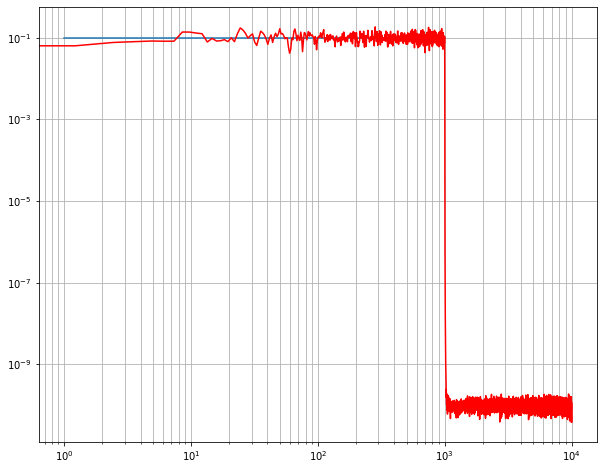

In [7]:
plt.figure(figsize=(10,8));
plt.loglog(freq,psd);
plt.loglog(freq_syn,psd_syn,'r-');
plt.grid(which='both');